# Baseline Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Local Train / Test set paths

In [3]:
# Link to your sample train_path (manually selected for now)
local_train_path = '../raw_data/SAMPLES/TRAIN_5K'
local_test_path = '../raw_data/SAMPLES/TEST_5K'

## Cloud paths - TO DO

In [4]:
# Need to link to cloud storage account hosting all sample folders already ready to use by the model
cloud_train_path = '..'
cloud_test_path = '..'

## Preprocessing - Loading Train & Test images as Tensorflow generators + VGG16 preproc

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

In [6]:
# ImageGenerator preprocess images / minimum params / to read .tif images
train_datagen = ImageDataGenerator(validation_split=0.2,preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
#preprocessing_function=preprocess_input

In [7]:
# Load from directory to flow passsed into ImageGenerator
train_generator = train_datagen.flow_from_directory(local_train_path,
                                                    subset='training',
                                                    target_size=(96,96),
                                                    batch_size=16,
                                                    class_mode='binary')

val_generator = train_datagen.flow_from_directory(local_train_path,
                                                  subset='validation',
                                                  target_size=(96,96),
                                                  batch_size=16,
                                                  class_mode='binary')
                        

test_generator = test_datagen.flow_from_directory(local_test_path,
                                                  target_size=(96,96),
                                                  class_mode='binary')

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
dim = train_generator[0][0].shape[1]
dim

96

In [9]:
train_generator[0][0]

array([[[[  23.060997  ,  -41.779     ,   -0.6800003 ],
         [  30.060997  ,  -31.779     ,    7.3199997 ],
         [   7.060997  ,  -48.779     ,  -12.68      ],
         ...,
         [ 122.061     ,  112.221     ,  120.32      ],
         [ 140.061     ,  138.22101   ,  131.32      ],
         [ 139.061     ,  138.22101   ,  125.32      ]],

        [[  -1.939003  ,  -60.779     ,  -21.68      ],
         [  -5.939003  ,  -61.779     ,  -25.68      ],
         [  62.060997  ,   12.221001  ,   45.32      ],
         ...,
         [ 139.061     ,  122.221     ,  131.32      ],
         [ 139.061     ,  130.22101   ,  131.32      ],
         [ 131.061     ,  129.22101   ,  120.32      ]],

        [[ 119.061     ,   72.221     ,  106.32      ],
         [  58.060997  ,   11.221001  ,   44.32      ],
         [  91.061     ,   47.221     ,   77.32      ],
         ...,
         [ 109.061     ,   84.221     ,  113.32      ],
         [ 149.061     ,  129.22101   ,  131.32      ],
  

## VGG16 Model Import - Transfer Learning

In [43]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

def load_model():
    model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape =(dim,dim,3)
    )
    return model

def set_nontrainable_layers(model):
    model.trainable = False
    return model

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(10, activation='relu')
    prediction_layer = layers.Dense(1, activation='sigmoid')
    dropout_layer = layers.Dropout(rate=0.20)
    
    model = models.Sequential([
        base_model,
        dropout_layer,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])
    return model

def build_model():
    model = load_model()
    model = add_last_layers(model)

    optim = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    return model


### Build the model

In [44]:
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

def build_model():
    model = load_model()
    model = add_last_layers(model)

    optim = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    return model

In [45]:
model = build_model()
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 dropout_1 (Dropout)         (None, 3, 3, 512)         0         
                                                                 
 flatten_14 (Flatten)        (None, 4608)              0         
                                                                 
 dense_28 (Dense)            (None, 10)                46090     
                                                                 
 dense_29 (Dense)            (None, 1)                 11        
                                                                 
Total params: 14,760,789
Trainable params: 46,101
Non-trainable params: 14,714,688
_________________________________________________________________


### Model Training

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

In [47]:
# Fitting the model using VGG16 first layers
model = build_model()
epochs = 1
batch_size = 16
es = EarlyStopping(patience=3, restore_best_weights=True,verbose=1)

history = model.fit(train_generator,
                    epochs = epochs,
                    validation_data=val_generator,
                    batch_size = batch_size, 
                    verbose = 1, 
                    callbacks = [es])

250/250 [==============================] - 379s 2s/step - loss: 0.6227 - accuracy: 0.7573 - val_loss: 0.4677 - val_accuracy: 0.8300


### Plot Loss & Accuracy charts FUNCTION

In [14]:
# Plot loss history function
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(16,4))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0.3,0.8))
    ax[0].legend(['Train', 'Val'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Val'], loc='best')
    ax[1].set_ylim((0.5,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

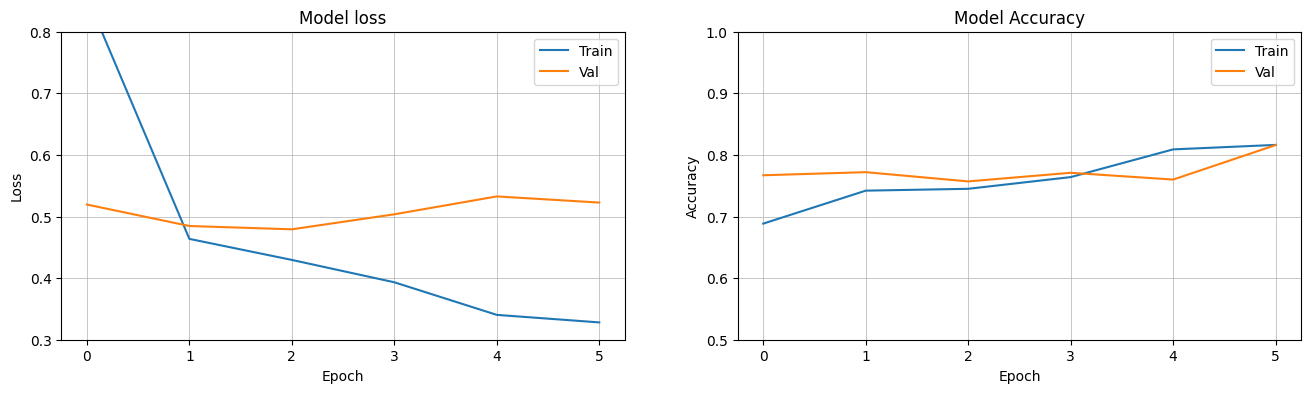

In [15]:
# Plot the loss & accuracy curves
plot_loss_accuracy(history)

### Model Evaluation

In [16]:
results = model.evaluate(test_generator, verbose = 1 )
print(f'The accuracy on the test set is of {results[1]*100:.2f} %')

32/32 [==============================] - 57s 2s/step - loss: 0.4398 - accuracy: 0.8090
The accuracy on the test set is of 80.90 %
